In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import plotly.offline as pyo

from IPython.display import display, Markdown


23.0


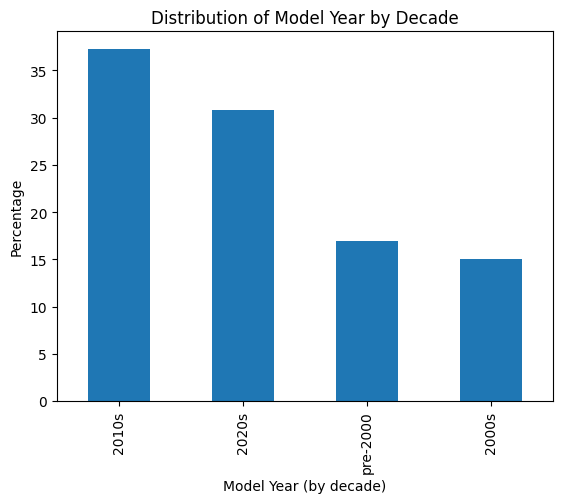

0      0
1      0
2      0
3      0
4      0
      ..
580    0
581    0
582    0
583    0
584    0
Name: Acura, Length: 585, dtype: int64

In [2]:
FILE_NAME = "doug_score.csv"
FILE_PATH = os.path.join(os.getcwd(), FILE_NAME)


def load_data(file_path: str) -> pd.DataFrame:
    df = pd.read_csv(FILE_PATH)
    return df


df = load_data(FILE_PATH)

# one hot encoding of brand column 
df = pd.concat([df, pd.get_dummies(df["brand"], drop_first=False).astype(int)], axis=1)
# one hot encoding of model column 
df = pd.concat([df, pd.get_dummies(df["model_year"], drop_first=False).astype(int)], axis=1)

# model year groupings
def bin_4(x: int):
    if x >= 2020: 
        return "2020s"
    if  x < 2020 and x >= 2010:
        return "2010s"
    if  x < 2010 and x >= 2000:
        return "2000s"
    return "pre-2000"

def bin_3(x: int):
    if x >= 2020: 
        return "2020s"
    if  x < 2020 and x > 2000:
        return "2000s"
    if x <= 2000:
        return "pre-2000"

def bin_2(x: int):
    if x >= 2020: 
        return "modern"
    if  x < 2000:
        return "vintage"
df['model_year_10'] = df['model_year'].apply(lambda x: 10 * int(x / 10))
df['model_year_4'] = df['model_year'].apply(bin_4)
df['model_year_3'] = df['model_year'].apply(bin_3)
df['model_year_2'] = df['model_year'].apply(bin_2)

# Here we handle missing data for video link by setting the video length to the median as it will probably be the least biased
missing_video_value = df['video_link'].apply(lambda x:  int(x.split(":")[0]) if x and not pd.isna(x) else 0).median() 
print(missing_video_value)
# parse time here is in minutes so we can maybe get a better signal to make decisions on
df['video_link_m'] = df['video_link'].apply(lambda x:   int(x.split(":")[0]) if x and not pd.isna(x) else missing_video_value) 
# parse time from "mm:ss" to 10minute buckets this will help us group the data more separably 
# df['video_link_10']= df['video_link'].apply(lambda x: 10 * int(x.split(":")[0]/10))

# here we do a light mapping to split the category of vehicle country into specific world regions
COUNTRY_MAP= {
    'Germany': 'Germany',
    'USA': 'North-America',
    'Japan': 'Asia',
    'South Korea': 'Asia',
}
# Because the data set is skewed towards german cars we will split categorie into european, european non german, north american and asian cars
df['vehicle_region'] = df['vehicle_country'].apply(lambda x: COUNTRY_MAP.get(x, 'Other Europe'))

# here we translate doug socres into quintiles
df['doug_quantile'] = pd.qcut(df['dougscore'], q=5, labels=False)

# generate histogram by percentage
(df['model_year_4'].value_counts(normalize=True)*100).plot(kind='bar')
plt.xlabel('Model Year (by decade)')
plt.ylabel('Percentage')
plt.title('Distribution of Model Year by Decade')
plt.show()


#one hot encoding of the model years 
df = pd.concat([df, pd.get_dummies(df["model_year"], drop_first=False, prefix="my").astype(int)], axis=1)
df = pd.concat([df, pd.get_dummies(df["model_year_10"], drop_first=False, prefix="my10").astype(int)], axis=1)
df = pd.concat([df, pd.get_dummies(df["model_year_4"], drop_first=False, prefix="my4").astype(int)], axis=1)
df = pd.concat([df, pd.get_dummies(df["model_year_3"], drop_first=False, prefix="my3").astype(int)], axis=1)
df = pd.concat([df, pd.get_dummies(df["model_year_2"], drop_first=False, prefix="my2").astype(int)], axis=1)
df['Acura']


In [3]:
# high level doug attributes bar charts
# calculate the average attribute score
import re
daily = ['d_comfort', 'd_practicality', 'd_value', 'd_features', 'd_quality']
weekend = ['w_acceleration', 'handling', 'w_funfactor', 'w_styling', 'w_cool_factor']
total = ['d_total', 'w_total', 'dougscore']
meta = ['brand', 'film_region', 'film_country', 'vehicle_region','model_year','video_link_m']

# Plot
import plotly.graph_objs as go
import plotly.express as px
import plotly.graph_objs as go

# Remove the ^ \w_ from the attribute names
daily_labels = [re.sub(r'^\w_', '', label) for label in daily]
weekend_labels = [re.sub(r'^\w_', '', label) for label in weekend]
total_labels = ["daily_labels","weekend_labels", "dougscore"]

fig = go.Figure()
fig.add_trace(go.Bar(x=daily_labels, y=df[daily].mean(), marker_color='skyblue'))

# Add titles and labels
fig.update_layout(title='Average Daily Attribute Scores', xaxis_title='Attributes', yaxis_title='Scores', yaxis_range=[0, df[daily].max() + 1])

fig.show()

fig = go.Figure()
fig.add_trace(go.Bar(x=weekend_labels, y=df[weekend].mean()))

# Add titles and labels
fig.update_layout(title='Average Weekend Attribute Scores', xaxis_title='Attributes', yaxis_title='Scores', yaxis_range=[0, df[weekend].max() + 1])

fig.show()

from plotly.subplots import make_subplots

# create subplots with two histograms
fig = make_subplots(rows=1, cols=2)

# add histogram for film_region
# fig.add_trace(go.Histogram(x=df['vehicle_region'], name='Vehicle Region'), row=1, col=1)

fig.add_trace(go.Histogram(x=df['video_link_m'], name='Film Duration in Minutes'), row=1, col=1,)

# add histogram for film_country
fig.add_trace(go.Histogram(x=df['film_country'], name='Film Country'), row=1, col=2)

# update layout
fig.update_layout(title='Histogram of Film Duration and Film Country', barmode='group')

# show plot
fig.show()

from plotly.subplots import make_subplots

# create subplots with two bar charts
fig = make_subplots(rows=1, cols=3)

# add bar chart for brands
brand_counts = df['brand'].value_counts()
vehicle_region_counts = df['vehicle_country'].value_counts()

fig.add_trace(go.Bar(x=brand_counts[:20].index, 
            y=brand_counts[:20].values, 
            name='Brand', 
            marker_color=px.colors.qualitative.Alphabet), 
        row=1, col=1)

# add bar chart for model years by decade
model_year_counts = df['model_year_10'].value_counts()
fig.add_trace(go.Bar(x=model_year_counts.index, 
            y=model_year_counts.values, 
            name='Model Year by Decade', 
            marker_color=px.colors.qualitative.Alphabet_r), 
        row=1, col=2)
fig.add_trace(go.Bar(x=vehicle_region_counts.index, 
            y=vehicle_region_counts.values, 
            name='Vehicle Country', 
            marker_color=px.colors.qualitative.D3), 
        row=1, col=3)

# update layout
fig.update_layout(title='Vehicle Region, Brands(Top 20 Brands) and Car Model Years by Decade ', barmode='group')


In [4]:
from plotly.subplots import make_subplots

# Define subplot layout
fig = make_subplots(rows=3, cols=3,
                    specs=[[{}, {}, {}], [{}, {}, {}], [{}, {}, {"type": "domain"}]],
                    subplot_titles=('1. Daily Attr. Score Distribution', '2. Weekend Attr. Score Distribution','3. Doug Score Distribution', '4. Film Duration', 
                                    '5. Film Country', '6.Vehicle Country','7. Model Year by Decade','8. Top 20 of 84 Brands', '9. Top 20 Brand distribution' ),
                    vertical_spacing=0.11)

# 1. Daily Attributes
# fig.add_trace(go.Bar(x=daily_labels, y=df[daily].mean(), marker_color='skyblue', name='Daily'), row=1, col=1)

# 2. Weekend Attributes
# fig.add_trace(go.Bar(x=weekend_labels, y=df[weekend].mean(), name='Weekend'), row=1, col=2)

# D3 colors
colors_d3 = px.colors.qualitative.D3

# 1. Daily Attributes
for idx, label in enumerate(daily):
    # Add violin plot for distribution
    fig.add_trace(go.Violin(y=df[label], 
                             x=[daily_labels[idx]]*len(df),
                             name=daily_labels[idx], 
                             box_visible=True,
                             line_color=colors_d3[idx], 
                             meanline_visible=True), 
                  row=1, col=1)
    

# 2. Weekend Attributes
for idx, label in enumerate(weekend):
    # Add violin plot for distribution
    fig.add_trace(go.Violin(y=df[label], 
                             x=[weekend_labels[idx]]*len(df),
                             name=weekend_labels[idx], 
                             box_visible=True,
                             line_color=colors_d3[idx], 
                             meanline_visible=True), 
                  row=1, col=2)
    
# 3. Total Attributes
for idx, label in enumerate(total):
    # Add violin plot for distribution
    fig.add_trace(go.Violin(y=df[label], 
                             x=[total_labels[idx]]*len(df),
                             name=total_labels[idx], 
                             box_visible=True,
                             line_color=colors_d3[idx], 
                             meanline_visible=True), 
                  row=1, col=3)
    
# 4. Film Duration
fig.add_trace(go.Histogram(x=df['video_link_m'], name='Film Duration'), row=2, col=1)

# 5. Film Country
fig.add_trace(go.Histogram(x=df['film_country'], name='Film Country'), row=2, col=2)

# 6. Vehicle Region
vehicle_region_counts = df['vehicle_country'].value_counts()
fig.add_trace(go.Bar(x=vehicle_region_counts.index, 
                     y=vehicle_region_counts.values, 
                     name='Vehicle Country', 
                     marker_color=px.colors.qualitative.D3), row=2, col=3)

# 7. Model Year by Decade
model_year_counts = df['model_year_10'].value_counts()
fig.add_trace(go.Bar(x=model_year_counts.index, 
                     y=model_year_counts.values, 
                     name='Model Year by Decade', 
                     marker_color=px.colors.qualitative.Alphabet_r), row=3, col=1)

# 8. Brands
brand_counts = df['brand'].value_counts()
fig.add_trace(go.Bar(x=brand_counts[:20].index, 
                     y=brand_counts[:20].values, 
                     name='Top 20 Brands',
                     marker_color=px.colors.qualitative.Alphabet), row=3, col=2)
fig.update_xaxes(tickangle=45, row=3, col=2, tickfont=dict(size=9))





total_counts = brand_counts.sum()
top_20_brands_percentage = brand_counts[:20] / total_counts * 100

# Add the pie chart to the subplot figure
fig.add_trace(go.Pie(labels=top_20_brands_percentage.index, 
                     values=top_20_brands_percentage.values, 
                     name='Top 20 Brands by % Represented',
                     marker=dict(colors=px.colors.qualitative.Alphabet)),
              row=3, col=3)
# Update layout
fig.update_layout(title_text="High Level Doug Score Data Overview From 584 Reviews", barmode='group', height=1200, showlegend=False)

# Show the plot
fig.show()
pyo.plot(fig, filename='doug_score.html')



'doug_score.html'

In [5]:
# generate top 5 
# Adjust the number of rows and columns for the subplot layout
total_features = daily + weekend + total[:-1]
num_rows = -(-len(total_features) // 3)  # This is a way to compute the ceiling of the division
num_cols = 3

feature_labels = [re.sub(r'^\w_', '', label) for label in total_features]
feature_labels = feature_labels[:-2] + ['daily score', 'weekend score']

# Create subplots with 3 columns for each row
fig = make_subplots(rows=num_rows, cols=num_cols, subplot_titles=feature_labels, vertical_spacing=0.1, horizontal_spacing=0.1)

# Loop through each feature and plot the top 5 cars
for idx, feature in enumerate(total_features):
    row = idx // 3 + 1
    col = idx % 3 + 1
    
    # Sort by feature and then by dougscore
    sorted_df = df.sort_values(by=[feature, 'dougscore'], ascending=[False, False]).head(5)
    
    # Create bar chart for each feature
    fig.add_trace(go.Bar(x=sorted_df['brand'] + ' ' +sorted_df['model_name'] + ' ' + sorted_df['model_year'].astype(str), 
                         y=sorted_df[feature], 
                         name=feature, 
                         text=sorted_df['dougscore'],
                         marker_color=px.colors.qualitative.Plotly),
                  row=row, col=col)
     
    # Update yaxis title to match feature name
    fig.update_yaxes(title_text=re.sub(r'^\w_', '', feature), row=row, col=col)

# Update layout
fig.update_layout(height=2000, width=1200, title_text="Top 5 Cars for Each Feature Sorted by Dougscore", showlegend=False)

fig.show()

In [6]:
# Define the joint columns and their titles again
joint_columns_list = [
    ["w_funfactor", "d_value", "d_practicality"],
    ["w_acceleration", "handling", "d_comfort"],
    ["w_styling", "w_cool_factor", "d_quality"],
    ["w_total", "d_total"]
]

def get_feature_name(feature: str) -> str:
    if(feature == "w_total"):
        return "weekend_score"
    if(feature == "d_total"):
        return "daily_score"
    return re.sub(r'^\w_', '', feature)

titles = ['A) Fun factor, value, practicality', 'B) Accleration, handling, comfort', 'C) Styling, cool factor, quality', 'D) Weekend, daily score']


# Recreate the enhanced heatmap with the necessary variables

# Create a 2x2 subplot
fig = make_subplots(rows=2, cols=2, subplot_titles=titles, vertical_spacing=0.065, horizontal_spacing=0.15)

# Loop over each set of joint columns and add them to the subplot
for idx, joint_columns in enumerate(joint_columns_list):
    new_df = pd.concat([df[col] for col in joint_columns], axis=1)

    correlation_matrix = np.corrcoef(new_df, rowvar=False)
    
    # Convert the correlation matrix to dataframe for easier handling with plotly
    df_corr = pd.DataFrame(correlation_matrix, columns=joint_columns, index=joint_columns)
    
    # Add the heatmap to the subplot
    heatmap = go.Heatmap(z=df_corr.values, x=joint_columns, y=joint_columns,  colorscale='RdBu', 
                         zmin=-1, zmax=1, showscale=True, hoverinfo="z",
                         colorbar=dict(len=0.3, y=((idx // 2) * 0.5 + 0.25)))
    
    fig.add_trace(heatmap, row=(idx // 2) + 1, col=(idx % 2) + 1)
    
    # Add annotations for displaying the correlation values inside the squares
    for i, x in enumerate(joint_columns):
        for j, y in enumerate(joint_columns):
            fig.add_annotation(
                go.layout.Annotation(
                    showarrow=False,
                    text="{:.2f}".format(correlation_matrix[i, j]),
                    xref="x" + str(idx + 1),
                    yref="y" + str(idx + 1),
                    x=x,
                    y=y,
                    font=dict(color="black" if correlation_matrix[i, j] < 0.7 else "white", size=10)
                ),
                row=(idx // 2) + 1, col=(idx % 2) + 1
            )

# Update layout
fig.update_layout(title="Correlation Matrix Heatmaps", height=900, width=900)

fig.show()

### Pearson Correlation for Fun factor, practicality, value


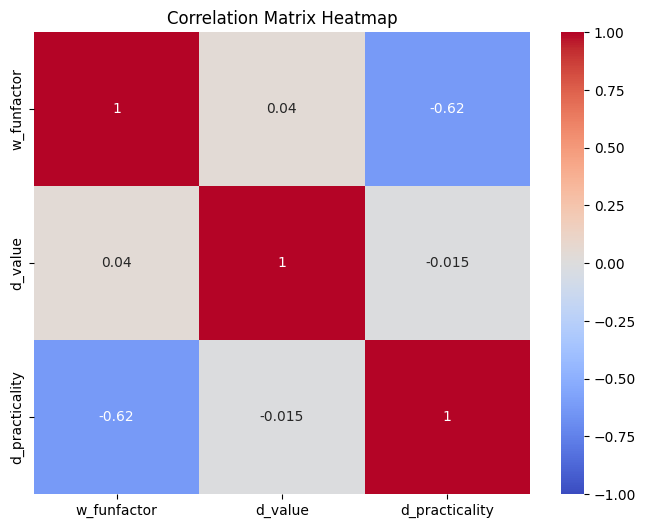

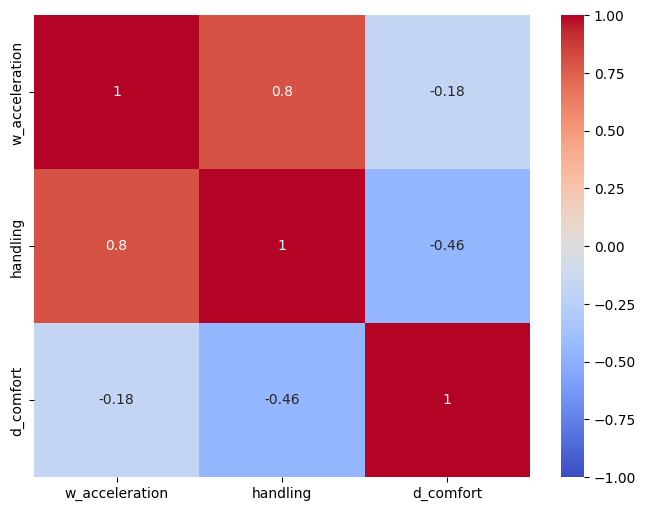

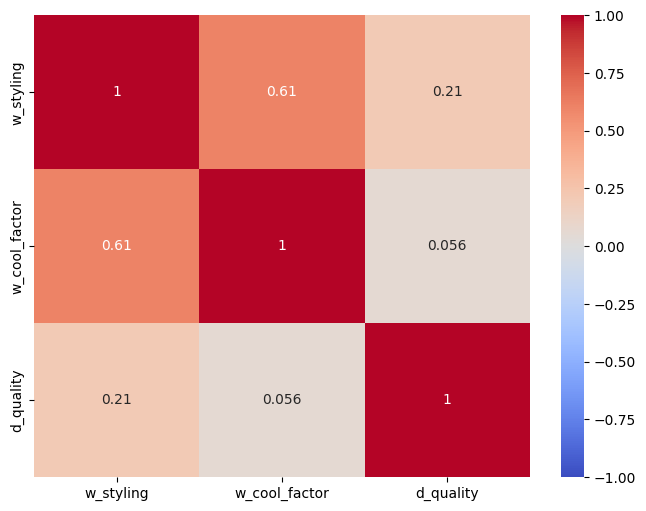

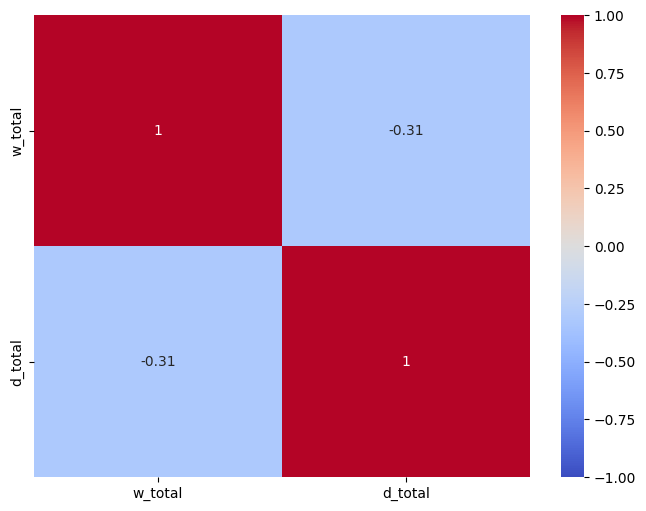

In [7]:

# overall the weekend factors seem to be only lightly or negatively correlated to the daily factors
# the sum of all the factors make a particular weekend or daily score so it makes some sense that the final score which is the sum of the 
# weekend and daily scores lands in the 70s if one of the other scores outweights the other , vs in the 90s 
# plt.show()
joint_columns = ["w_funfactor", "d_value", "d_practicality"]
new_df = pd.concat([df[col] for col in joint_columns],axis=1)

# calculate pairwise correlation
correlation_matrix = np.corrcoef(new_df, rowvar=False)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, xticklabels=joint_columns, yticklabels=joint_columns)
plt.title('Correlation Matrix Heatmap')

joint_columns = ["w_acceleration", "handling", "d_comfort"]
new_df = pd.concat([df[col] for col in joint_columns],axis=1)

# calculate pairwise correlation
correlation_matrix = np.corrcoef(new_df, rowvar=False)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, xticklabels=joint_columns, yticklabels=joint_columns)
plt.show()

# Styl0ng, cool factor, quality
joint_columns = ["w_styling", "w_cool_factor", "d_quality"]
new_df = pd.concat([df[col] for col in joint_columns],axis=1)

# calculate pairwise correlation
correlation_matrix = np.corrcoef(new_df, rowvar=False)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, xticklabels=joint_columns, yticklabels=joint_columns)
plt.show()

# Styl0ng, cool factor, quality
# Weekend score, daily score, brand

joint_columns = ["w_total", "d_total"]
new_df = pd.concat([df[col] for col in joint_columns],axis=1)

# calculate pairwise correlation for weekend and daily score
correlation_matrix = np.corrcoef(new_df, rowvar=False)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, xticklabels=joint_columns, yticklabels=joint_columns)
plt.show()


In [8]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Regression for daily score
print (df[df['brand'].unique()])
X = sm.add_constant(df[df['brand'].unique()])
y_daily = df["d_total"]
model_daily = sm.OLS(y_daily, X).fit()

# Regression for weekend score
y_weekend = df['w_total']
model_weekend = sm.OLS(y_weekend, X).fit()

# Create subplots
fig = make_subplots(rows=1, cols=3, 
                    subplot_titles=("Adjusted R-squared", "Top 20 for Daily Score", "Top 20 for Weekend Score"))

# 1. Bar chart for adjusted R-squared values
r_squared_values = [model_daily.rsquared_adj, model_weekend.rsquared_adj]
score_types = ["Daily Score", "Weekend Score"]
fig.add_trace(go.Bar(x=score_types, y=r_squared_values, marker_color='lightblue'), row=1, col=1)

# 2. Top 20 brands for daily score
# For daily score
# First, sort by p-values, then by the absolute value of coefficients
sorted_indices_daily = np.argsort((model_daily.pvalues.values[1:], np.abs(model_daily.params.values[1:])))


#top_brands_daily = model_daily.params.index[sorted_indices_daily + 1]
#top_coefficients_daily = model_daily.params.values[sorted_indices_daily + 1]
#top_p_values_daily = model_daily.pvalues.values[sorted_indices_daily + 1]

# Create a DataFrame from parameters and p-values
df_params = pd.DataFrame({
    'brand': model_daily.params.index[1:],
    'coefficient': model_daily.params.values[1:],
    'p_value': model_daily.pvalues.values[1:]
})

# Sort by p-values, then by the absolute value of coefficients
df_sorted = df_params.sort_values(by=['p_value', 'coefficient'], key=lambda col: np.abs(col) if col.name == 'coefficient' else col)

# Get the sorted values
top_brands_daily = df_sorted['brand'].values[:20]
top_coefficients_daily = df_sorted['coefficient'].values[:20]
top_p_values_daily = df_sorted['p_value'].values[:20]

fig.add_trace(go.Bar(
    x=top_brands_daily,
    y=top_coefficients_daily,
    marker_color=['red' if p < 0.05 else 'blue' for p in top_p_values_daily]
), row=1, col=2)

# 3. Top 20 brands for weekend score
# For weekend score
# First, sort by p-values, then by the absolute value of coefficients
# Create a DataFrame from parameters and p-values
df_params = pd.DataFrame({
    'brand': model_weekend.params.index[1:],
    'coefficient': model_weekend.params.values[1:],
    'p_value': model_weekend.pvalues.values[1:]
})

# Sort by p-values, then by the absolute value of coefficients
df_sorted = df_params.sort_values(by=['p_value', 'coefficient'], key=lambda col: np.abs(col) if col.name == 'coefficient' else col)
top_brands_weekend = df_sorted['brand'].values[:20]
top_coefficients_weekend = df_sorted['coefficient'].values[:20]
top_p_values_weekend = df_sorted['p_value'].values[:20]

fig.add_trace(go.Bar(
    x=top_brands_weekend,
    y=top_coefficients_weekend,
    marker_color=['red' if p < 0.05 else 'blue' for p in top_p_values_weekend]
), row=1, col=3)

# Update layout
fig.update_layout(title="Impact of Brands on Scores", template="plotly_white", showlegend=False)

# Show the plot
fig.show()

     McLaren  Lucid  GMC  Rivian  Tesla  Bugatti  Ferrari  Mercedes  Rimac  \
0          1      0    0       0      0        0        0         0      0   
1          1      0    0       0      0        0        0         0      0   
2          0      1    0       0      0        0        0         0      0   
3          0      0    1       0      0        0        0         0      0   
4          0      0    0       1      0        0        0         0      0   
..       ...    ...  ...     ...    ...      ...      ...       ...    ...   
580        0      0    0       0      0        0        0         0      0   
581        0      0    0       0      0        0        0         0      0   
582        0      0    0       0      0        0        0         0      0   
583        0      0    0       0      0        0        0         0      0   
584        0      0    0       0      0        0        0         0      0   

     Koenigsegg  ...  Saab  Oldsmobile  Smart  Isuzu  Volga  Lo

In [9]:
# a regression model for the affect of brand on the weekend score
import statsmodels.api as sm
from statsmodels.formula.api import ols

# create a model for the weekend score
joint_columns = []
# joint_columns.extend(["w_total"])
joint_columns.extend(df['brand'].unique())
X = sm.add_constant(df[joint_columns])
y = df["d_total"]
model = sm.OLS(y, X).fit()
print("Daily total score Adjusted. R-squared", model.rsquared_adj)
# here we say brand explains 45.9% of the variation in the daily score

# I also applied brand with the weekend score, but it accounted for a very small percentage 2% change in the r^2 value
y = df['w_total']
X = sm.add_constant(df[joint_columns])
model = sm.OLS(y, X).fit()
print("Weekend total score Adjusted. R-squared", model.rsquared_adj)

# in this case brand accounted for 49% of the variation in the weekend score
# and in the case of the daily score it accounted for 34.4% 

# This leads us to conclude that brand does matter in the weekend score, but not as much as the daily score 



Daily total score Adjusted. R-squared 0.34476332916618013
Weekend total score Adjusted. R-squared 0.49016770728384407


In [10]:
# Weekend score, daily score, model year
# create a model for the weekend score
from statsmodels.regression.linear_model import RegressionResultsWrapper

# Here we regress across the different buckets for model year , the decade model, the 4 bucket model, and the 3 bucket model
daily = df["d_total"]
weekend = df["w_total"]

def get_model_year_regression(df: pd.DataFrame, y, model_year_prefix: str, model_year_column)-> RegressionResultsWrapper :
    joint_columns = df['model_year'].unique()
    if(model_year_prefix != ""):
        joint_columns =model_year_column.apply(lambda x: model_year_prefix + "_" + str(x)).unique()
    X = sm.add_constant(df[joint_columns])
    model = sm.OLS(y, X).fit()
    return model

print("Daily Score Model Year Regression")
print("Rsquared for by model year", get_model_year_regression(df, daily, "", df['model_year']).rsquared_adj)
print("Rsquared for by decade grouping", get_model_year_regression(df, daily, "my10", df["model_year_10"]).rsquared_adj)
print("Rsquared for by 2020s 2010s  2000s pre-2000s grouping", get_model_year_regression(df, daily, "my4", df["model_year_4"]).rsquared_adj)
print("Rsquared for by 2020s 2000s pre-2000s grouping", get_model_year_regression(df, daily, "my3", df["model_year_3"]).rsquared_adj)
# print("Rsquared for by modern vintage grouping", get_model_year_regression(df, daily, "my2", df["model_year_2"]).rsquared)

print("\nWeekend Score Model Year Regression")
print("Rsquared for by model year", get_model_year_regression(df, weekend, "", df['model_year']).rsquared_adj)
print("Rsquared for by decade grouping", get_model_year_regression(df, weekend, "my10", df["model_year_10"]).rsquared_adj)
print("Rsquared for by 2020s 2010s  2000s pre-2000s grouping", get_model_year_regression(df, weekend, "my4", df["model_year_4"]).rsquared_adj)
print("Rsquared for by 2020s 2000s pre-2000s grouping", get_model_year_regression(df, weekend, "my3", df["model_year_3"]).rsquared_adj)
# print("Rsquared for by modern vintage grouping", get_model_year_regression(df, weekend, "my2", df["model_year_2"]).rsquared)

# joint_columns.extend(["w_total"])

#there was 46.2%  explaination in change in the daily score

#there was 10.0%  explaination in change in the weekend score

Daily Score Model Year Regression
Rsquared for by model year 0.4190942791678066
Rsquared for by decade grouping 0.35334517915526487
Rsquared for by 2020s 2010s  2000s pre-2000s grouping 0.348010268546195
Rsquared for by 2020s 2000s pre-2000s grouping 0.29124489984477475

Weekend Score Model Year Regression
Rsquared for by model year 0.020802421515331848
Rsquared for by decade grouping 0.03374599235867337
Rsquared for by 2020s 2010s  2000s pre-2000s grouping 0.034323557516745096
Rsquared for by 2020s 2000s pre-2000s grouping 0.031473449217343075


In [11]:
# Get adjusted R-squared values for daily and weekend scores
daily_r2_values = [
    get_model_year_regression(df, daily, "my", df['model_year']).rsquared_adj,
    get_model_year_regression(df, daily, "my10", df["model_year_10"]).rsquared_adj,
    get_model_year_regression(df, daily, "my4", df["model_year_4"]).rsquared_adj,
    get_model_year_regression(df, daily, "my3", df["model_year_3"]).rsquared_adj
]

weekend_r2_values = [
    get_model_year_regression(df, weekend, "my", df['model_year']).rsquared_adj,
    get_model_year_regression(df, weekend, "my10", df["model_year_10"]).rsquared_adj,
    get_model_year_regression(df, weekend, "my4", df["model_year_4"]).rsquared_adj,
    get_model_year_regression(df, weekend, "my3", df["model_year_3"]).rsquared_adj
]

groupings = ["By Model Year", "By Decade", "By 2020s 2010s 2000s pre-2000s", "2020s 2000s pre-2000s"]

# Create bar plot
fig = go.Figure()

# Daily Score bars
fig.add_trace(go.Bar(
    x=groupings,
    y=daily_r2_values,
    name='Daily Score',
    marker_color='blue'
))

# Weekend Score bars
fig.add_trace(go.Bar(
    x=groupings,
    y=weekend_r2_values,
    name='Weekend Score',
    marker_color='red'
))

# Update layout
fig.update_layout(
    title="Adjusted R-squared Values for Different Model Year Groupings",
    xaxis_title="Model Year Groupings",
    yaxis_title="Adjusted R-squared",
    barmode='group',
    template="plotly_white"
)

# Show the plot
fig.show()

In [12]:
# Create subplots
import math
fig = make_subplots(rows=2, cols=2, 
                    subplot_titles=("By Model Year", "By Decade", "By 4 Buckets", "By 3 Buckets"))

grouping_prefixes = ["my", "my10", "my4", "my3"]
grouping_model = ["model_year", "model_year_10", "model_year_4", "model_year_3"]
grouping_titles = ["By Model Year", "By Decade", "By 4 Buckets", "By 3 Buckets"]

for i, prefix in enumerate(grouping_prefixes):
    # Regression for the given model year grouping
    model = get_model_year_regression(df, daily, prefix, df[grouping_model[i]])

    # 2. Top 20 model years for daily score based on p-values and coefficient magnitude
    df_params = pd.DataFrame({
        'model_year': model.params.index[1:],
        'coefficient': model.params.values[1:],
        'p_value': model.pvalues.values[1:]
    })
    df_sorted = df_params.sort_values(by=['p_value', 'coefficient'], key=lambda col: np.abs(col) if col.name == 'coefficient' else col)
    top_model_years = df_sorted['model_year'].apply(lambda x: x.split("_")[-1]).values[:20] # remove prefixes
    top_coefficients = df_sorted['coefficient'].values[:20]
    top_p_values = df_sorted['p_value'].values[:20]
    fig.add_trace(go.Bar(
        x=top_model_years,
        y=top_coefficients,
        marker_color=['red' if p < 0.05 else 'blue' for p in top_p_values]
    ), row=math.floor(i//2)+1, col=(i%2)+1)


caption = "<b>Color Legend:</b><br>Red: p-value < 0.05 statistically significant<br>Blue: p-value >= 0.05 statistically insignificant"
annotations=[
        {
            'text': caption,
            'xref': 'paper', 'yref': 'paper',
            'x': 0.5, 'y': -0.15, # x and y position
            'xanchor': 'center', 'yanchor': 'top',
            'showarrow': False,
            'font': {'size': 12}
        }]
# Update layout
fig.update_layout(title="Impact of Model Year Groupings on Daily Score", template="plotly_white", showlegend=False,
    margin=dict(b=100), # Adding right margin for the legend
        annotations=annotations
                  )

# Show the plot
fig.show()

In [25]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold,KFold, cross_validate
import pandas as pd
import matplotlib.pyplot as plt
import shap
import re
import itertools

def generate_subsets(daily, weekend, meta):
    # Create an empty list to store the results
    result = []

    # Generate combinations for each category
    for d_len in range(len(daily) + 1):
        for d_comb in itertools.combinations(daily, d_len):
            for w_len in range(len(weekend) + 1):
                for w_comb in itertools.combinations(weekend, w_len):
                    for m_len in range(len(meta) + 1):
                        for m_comb in itertools.combinations(meta, m_len):
                            result.append((list(d_comb), list(w_comb), list(m_comb)))

    return result

def train_and_plot_tree(df, 
                        daily_columns=[], 
                        weekend_columns=[], 
                        meta_columns=[], 
                        criteria=None, 
                        quantile=5,
                        tree_depth=5,
                        show_plot=True):
    
    filtered_df = df
    # Apply criteria if provided
    if criteria:
        filtered_df = df[criteria(df)]

    # Combine the columns
    active_columns = []
    active_columns.extend(daily_columns)
    active_columns.extend(weekend_columns)
    active_columns.extend(meta_columns)

    # Preprocess data
    X = filtered_df[active_columns]
    X.reset_index(drop=True, inplace=True)
    cat_features = meta_columns
    encoder = OneHotEncoder()
    X_encoded = encoder.fit_transform(X[cat_features])
    X_encoded_df = pd.DataFrame(X_encoded.toarray(), columns=encoder.get_feature_names_out(cat_features))
    X = pd.concat([X.drop(cat_features, axis=1), X_encoded_df], axis=1)
    filtered_df['doug_quantile'] = pd.qcut(df['dougscore'], q=quantile, labels=False)
    y = filtered_df['doug_quantile']
    # Train the decision tree
    clf = DecisionTreeClassifier(max_depth=tree_depth, criterion='gini', random_state=42, min_samples_leaf=10, min_samples_split=10)
    
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_results = cross_validate(clf, X, y, cv=stratified_kfold, return_train_score=True)
    """ 
    print('Training scores:', cv_results['train_score'])
    print('Validation scores:', cv_results['test_score'])
    print('Mean training score:', cv_results['train_score'].mean())
    print('Mean validation score:', cv_results['test_score'].mean())
    """
    mean_test_score = cv_results['test_score'].mean()
    mean_train_score = cv_results['train_score'].mean()
    
    clf.fit(X, y)
    if(show_plot):
        shap.initjs()
    explainer = shap.TreeExplainer(clf)#.shap_values(df[daily + weekend + meta])
    # Compute SHAP values for the first instance in the dataset

    # Compute SHAP values for all instances in the dataset
    shap_values = explainer.shap_values(X)

    # Compute the mean absolute SHAP values for each feature for each class
    class_names_dict= {2: ['Bad', 'Good'], 3: ['Bad', 'Average', 'Good'], 5: [
        'Poor', 'Below Average', 'Average', 'Above Average', 'Good'
    ]}
    class_names = class_names_dict[len(shap_values)]  # replace with your actual class names
    feature_names=X.columns.map(lambda x: re.sub("^\w_", "",x))
    # Visualize the summary of SHAP values with a summary plot
    if show_plot:
        shap.summary_plot(shap_values, X, feature_names=feature_names, max_display=5, class_names=class_names)
        plt.show()
    N = 8  

    from scipy.stats import kstest
    # Get the SHAP values for class 0
    # print(np.shape(shap_values[1]))
    shap_values_class_0 = shap_values[1]

    # Flatten the SHAP values to a 1D array
    shap_values_class_0 = shap_values_class_0

    # Standardize the SHAP values to have mean 0 and variance 1
    shap_values_class_0 = (shap_values_class_0 - np.mean(shap_values_class_0)) / np.std(shap_values_class_0)
    # Perform the Kolmogorov-Smirnov test
    for i in range(len(shap_values_class_0[0])):
        stat, p = kstest(shap_values_class_0[i], 'norm')
        # print('Statistics=%.3f, p=%.10f' % (stat, p)) 

    from scipy.stats import kurtosis

    # print(np.shape(shap_values_class_0))
    # data_kurtosis = kurtosis(shap_values_class_0, axis=0)
    # print("kurtosis data",data_kurtosis)

    # plt.hist(shap_values_class_0, bins=20)
    # plt.show()


    # For each class
    for i in range(len(shap_values)):
        # Compute the mean absolute SHAP values for each feature
        mean_shap_values = np.mean(np.abs(shap_values[i]), axis=0)
        # Get the indices of the top n features
        top_n_indices = np.argsort(mean_shap_values)[-N:]
        # Get the mean SHAP values for the top n features
        top_n_mean_shap_values = mean_shap_values[top_n_indices]
        # Compute the relative importance of each feature
        relative_importance = top_n_mean_shap_values / np.sum(top_n_mean_shap_values)
        if show_plot:
            # Create a pie chart
            plt.figure()
            plt.pie(relative_importance, labels=feature_names[top_n_indices], autopct='%1.1f%%',colors=plt.cm.Set3(np.arange(len(X.columns[top_n_indices]))))
            plt.title(f'Relative Feature Importance - {class_names[i]}')

            plt.show()
    #shap.dependence_plot("w_acceleration", shap_values[2], X)

    # Plot the tree
    if show_plot:
        plt.figure(figsize=(80,40))
        plot_tree(clf, feature_names=list(X.columns), class_names=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'], filled=True)
        plt.show()
    # Compute SHAP values
    # For each class
    for i in range(len(shap_values)):
        # print(f'Median shapely value: for {class_names[i]} Cars:')
        # Compute average SHAP values for each feature
        avg_shap_values = np.mean(shap_values[i], axis=0)
        # Print the average SHAP values
        for feature, value in zip(X.columns, avg_shap_values):
            f_name = re.sub("^\w_","",feature)
            # print(f'{f_name}: {value}') 
        shap_df = pd.DataFrame({'feature': X.columns, 'shap_value': avg_shap_values})
    return  (clf,[daily_columns,weekend_columns,meta_columns],cv_results,mean_test_score,mean_train_score, shap_values)

In [66]:
from sklearn.calibration import cross_val_predict
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor, plot_tree

# Ignore ConvergenceWarning
def train_and_plot_tree_regression(df, 
                        daily_columns=[], 
                        weekend_columns=[], 
                        meta_columns=[], 
                        criteria=None, 
                        tree_depth=5,
                        show_plot=True):
    
    # ... [rest of the preprocessing remains the same]
    filtered_df = df
    # Apply criteria if provided
    if criteria:
        filtered_df = df[criteria(df)]

    # Combine the columns
    active_columns = []
    active_columns.extend(daily_columns)
    active_columns.extend(weekend_columns)
    active_columns.extend(meta_columns)

    # Preprocess data
    X = filtered_df[active_columns]
    X.reset_index(drop=True, inplace=True)
    cat_features = meta_columns
    encoder = OneHotEncoder()
    X_encoded = encoder.fit_transform(X[cat_features])
    X_encoded_df = pd.DataFrame(X_encoded.toarray(), columns=encoder.get_feature_names_out(cat_features))
    X = pd.concat([X.drop(cat_features, axis=1), X_encoded_df], axis=1)

    # For regression, use the continuous 'dougscore' as the target variable
    y = filtered_df['dougscore']

    # Train the regression tree
    reg = DecisionTreeRegressor(max_depth=tree_depth, random_state=42, min_samples_split=10)
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_results = cross_validate(reg, X, y, cv=kfold, scoring=['neg_mean_squared_error'], return_train_score=True)
        # Fit the model and make predictions
    y_pred = cross_val_predict(reg, X, y, cv=kfold)

    # Calculate the MAPE
    mape = mean_absolute_percentage_error(y, y_pred)

    """ 
    print('Training MSE:', -cv_results['train_neg_mean_squared_error'])
    print('Validation MSE:', -cv_results['test_neg_mean_squared_error'])
    print('Mean training MSE:', -cv_results['train_neg_mean_squared_error'].mean())
    print('Mean validation MSE:', -cv_results['test_neg_mean_squared_error'].mean())
    """

    # make this the RMSE
    mean_train_score = np.sqrt(-cv_results['train_neg_mean_squared_error'].mean())
    mean_test_score = np.sqrt(-cv_results['test_neg_mean_squared_error'].mean())
    reg.fit(X, y)
    #shap.initjs()
    explainer = shap.TreeExplainer(reg)
    shap_values = explainer.shap_values(X)

    # Visualize the summary of SHAP values with a summary plot
    if show_plot:
        shap.summary_plot(shap_values, X, max_display=5)
        plt.show()

    # ... [rest of the SHAP value analysis remains the same]

    # Plot the tree
    if show_plot:
        plt.figure(figsize=(80,40))
        plot_tree(reg, feature_names=list(X.columns), filled=True)
        plt.show()

    # Compute average SHAP values for each feature
    avg_shap_values = np.mean(shap_values, axis=0)
    # Print the average SHAP values
    for feature, value in zip(X.columns, avg_shap_values):
        f_name = re.sub("^\w_","",feature)
        # print(f'{f_name}: {value}') 

    return  (reg,[daily_columns,weekend_columns,meta_columns],cv_results,mape, mean_test_score,mean_train_score, zip(X.columns, avg_shap_values))

In [67]:

# This gives us the ability to search for the best combination of features to use in the model
# to show case the decisions and to dive a bit deeper into it
import plotly.graph_objs as go
from plotly.subplots import make_subplots

def generate_subplots(total_results_list, filter_criteria, sort_criteria, title_prefix):
    fig = make_subplots(rows=len(total_results_list), cols=1, subplot_titles=[f"{title_prefix} (Model {i+1})" for i in range(len(total_results_list))])
    
    for i, total_results in enumerate(total_results_list):
        total_results_sorted = sorted(total_results, key=sort_criteria, reverse=True)
        filtered_results = list(filter(filter_criteria, (map(lambda x: (x[1], x[3]), total_results_sorted))))
        parsed_data = []
        for entry in filtered_results:
            features = [re.sub(r'^\w_', '', feature) for subset in entry[0] for feature in subset]
            parsed_data.append((", ".join(features), entry[1]))

        # Split features and accuracy scores for plotting
        features, accuracy_scores = zip(*parsed_data)

        # Add subplot to the figure
        fig.add_trace(go.Bar(x=features, y=accuracy_scores, marker_color=px.colors.qualitative.Alphabet), row=i+1, col=1)

    fig.update_layout(height=800, showlegend=False)
    fig.show()


In [65]:
daily = ['d_comfort', 'd_practicality', 'd_value', 'd_features', 'd_quality']
weekend = ['w_acceleration', 'handling', 'w_funfactor', 'w_styling', 'w_cool_factor']
meta = ['brand', 'film_region', 'film_country', 'vehicle_region','model_year_10','video_link_m']

def generate_n_subsets(daily, weekend, meta, n):
    # Combine all three lists
    combined = daily + weekend + meta
    
    # Generate combinations of size n from the combined list
    combinations = list(itertools.combinations(combined, n))
    
    # Convert combinations to desired format
    result = []
    for comb in combinations:
        daily_subset = [item for item in comb if item in daily]
        weekend_subset = [item for item in comb if item in weekend]
        meta_subset = [item for item in comb if item in meta]
        result.append((daily_subset, weekend_subset, meta_subset))
    
    return result



two_feature_results = []
three_feature_results = []

# Generate subsets of size 2 and 3
two_feature_subsets = generate_n_subsets(daily, weekend, meta, 2)
three_feature_subsets = generate_n_subsets(daily, weekend, meta, 3)

two_feature_regression_results = []
three_feature_regression_results = []


# Train and plot trees for each subset
for subset in two_feature_subsets:
    two_feature_results.append(train_and_plot_tree(df, daily_columns=subset[0], weekend_columns=subset[1], meta_columns=subset[2], criteria=None, quantile=2, tree_depth=5, show_plot=False))
    two_feature_regression_results.append(train_and_plot_tree_regression(df, daily_columns=subset[0], weekend_columns=subset[1], meta_columns=subset[2], criteria=None, tree_depth=5, show_plot=False))

for subset in three_feature_subsets:
    three_feature_results.append(train_and_plot_tree(df, daily_columns=subset[0], weekend_columns=subset[1], meta_columns=subset[2], criteria=None, quantile=2, tree_depth=5, show_plot=False))
    three_feature_regression_results.append(train_and_plot_tree_regression(df, daily_columns=subset[0], weekend_columns=subset[1], meta_columns=subset[2], criteria=None, tree_depth=5, show_plot=False))

classifier_prefix = "Features with over 90% Accuracy for Doug Score prediction"
regression_prefix = "MAPE: For features with under 10% error for Doug Score prediction"

# the data is transformed prior to filtering into a tuple of (columns, test_accuracy)
def threshold_90(tree_tuple):
    return tree_tuple[1] > 0.90

# works over the raw data
def default_criteria(tree_tuple):
    return tree_tuple[3]

# scaling this by 49 the total range of possible values to then say if the rmse is less than 10% of the total range of values then it is a good model
def r_filter_criteria(tree_tuple):
    return tree_tuple[1] < 0.10

generate_subplots([two_feature_results, three_feature_results], threshold_90, default_criteria, classifier_prefix)

generate_subplots([two_feature_regression_results, three_feature_regression_results], r_filter_criteria, lambda x: - default_criteria(x), regression_prefix)


MAPE: 0.14531015831185567
MAPE: 0.16192213559882168
MAPE: 0.12264859699277036
MAPE: 0.12239230707661358
MAPE: 0.06512957755611232
MAPE: 0.0793100546022534
MAPE: 0.0750260939916362
MAPE: 0.1018911616258079
MAPE: 0.11197681260787443
MAPE: 0.14540638331452846
MAPE: 0.15847026162150765
MAPE: 0.15891366519005634
MAPE: 0.1425956400594798
MAPE: 0.13373801390758283
MAPE: 0.15892251794153148
MAPE: 0.1575472486238038
MAPE: 0.11008392927710083
MAPE: 0.11873937300201007
MAPE: 0.06914241365229332
MAPE: 0.08762353636664207
MAPE: 0.09070115128813695
MAPE: 0.11251384596807348
MAPE: 0.12404177309049431
MAPE: 0.1508430612360868
MAPE: 0.15966832884180712
MAPE: 0.1581704221575025
MAPE: 0.1430782073590222
MAPE: 0.12999310685564522
MAPE: 0.15812007778432352
MAPE: 0.12705739146737866
MAPE: 0.12091481163036087
MAPE: 0.07154980390793729
MAPE: 0.10655463092612966
MAPE: 0.1066103598349822
MAPE: 0.11362003422504846
MAPE: 0.1290936099228449
MAPE: 0.14623506618293727
MAPE: 0.15923308126654426
MAPE: 0.15624310834210

vehicle_region
Germany          167
Other Europe     165
North-America    128
Asia             125
Name: count, dtype: int64
Training scores: [0.92735043 0.92948718 0.92307692 0.93589744 0.9508547 ]
Validation scores: [0.91452991 0.88034188 0.91452991 0.94017094 0.90598291]
Mean training score: 0.9333333333333333
Mean validation score: 0.9111111111111111


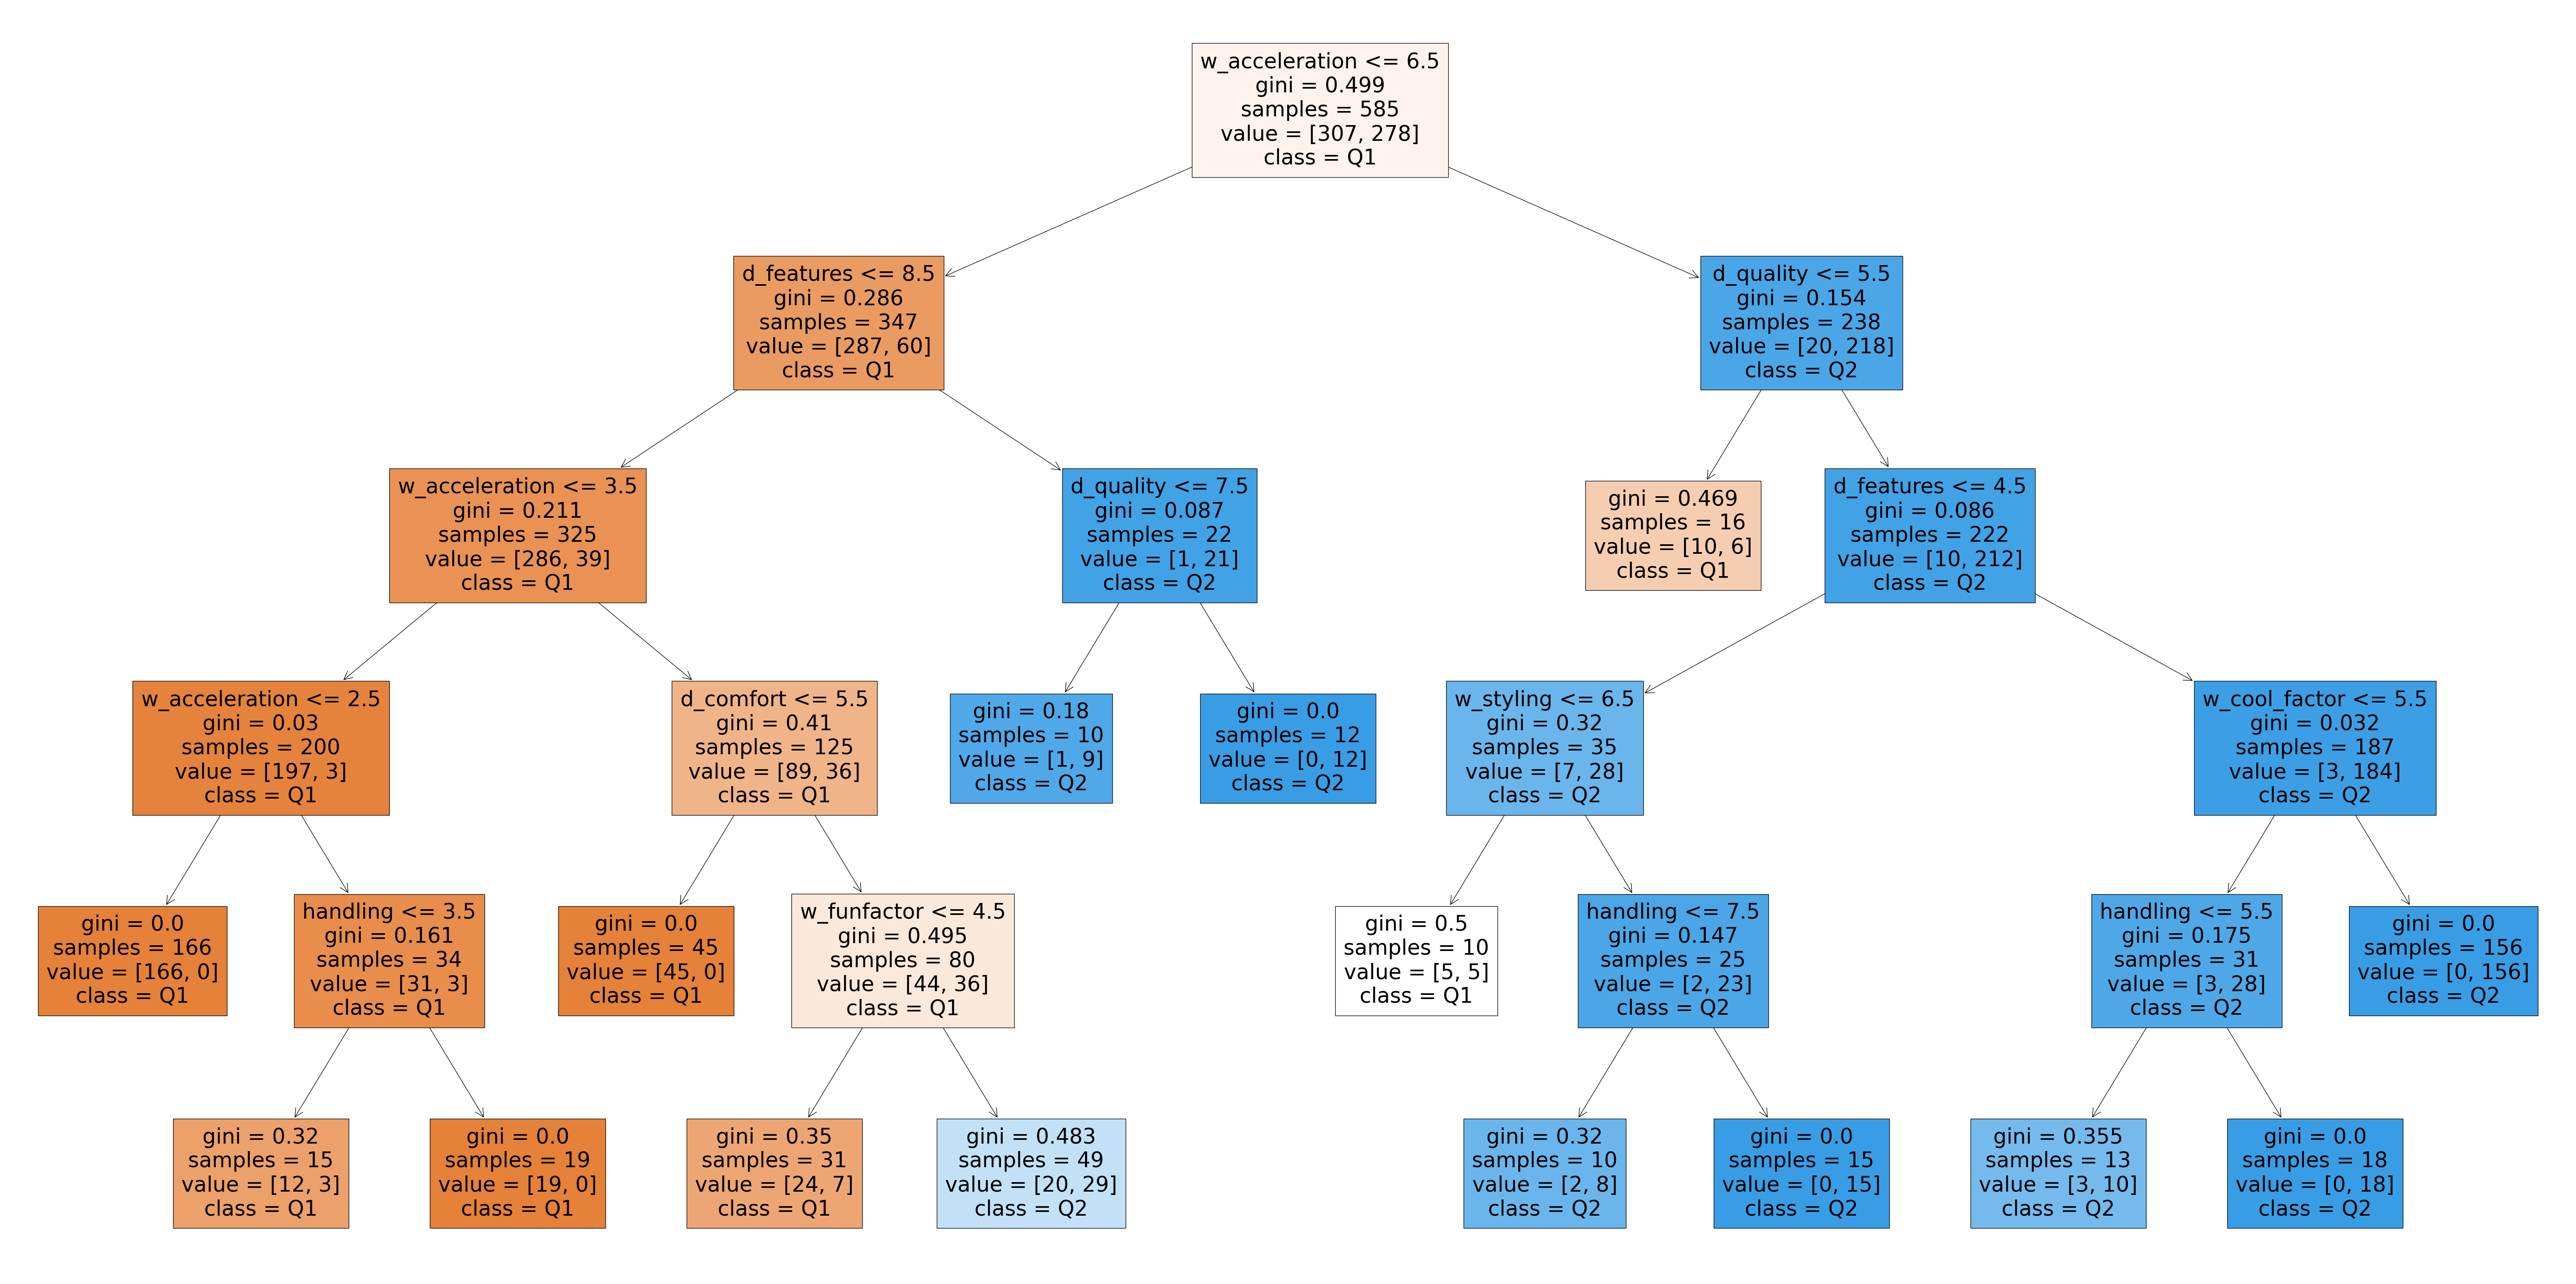

In [49]:

from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

# here we're taking a look at the splitting up the doug score into categories binning it into quintiles
# this will allow us to see the distribution of the doug score to predict the quintile bottom 20%, to top 20% of cars
# we can also extend this to decile
df[['dougscore','w_total','d_total']]
df[['d_comfort','d_total','d_practicality','d_value','d_features','d_quality']]
df[['handling','w_acceleration','w_funfactor','w_styling','w_cool_factor', 'w_total']]
df[['brand','film_region','film_country','vehicle_country']]

# capture this
# df['vehicle_country'].value_counts()
# df['doug_quantile']=df[['dougscore']].quantile([0.2,0.4,0.6,0.8,1.0])
# here we translate into quintiles
df['doug_quantile'] = pd.qcut(df['dougscore'], q=2, labels=False)





# nice to see the quantlies by year
df[['doug_quantile','brand', 'model_year']].sort_values(by=['doug_quantile','model_year'], ascending=False)

# here we translate vehicle_country to vehicle region 


print(df['vehicle_region'].value_counts())
filtered_columns_daily =['d_comfort','d_practicality','d_value','d_features','d_quality']
filtered_columns_weekend =['w_acceleration','handling','w_funfactor','w_styling','w_cool_factor']
filtered_columns_meta=['brand','film_region','film_country','vehicle_region']




active_columns = []
active_columns.extend(filtered_columns_daily)
active_columns.extend(filtered_columns_weekend)
active_columns.extend(filtered_columns_meta)



X = df[active_columns]
cat_features = filtered_columns_meta # ['brand', 'film_region', 'film_country', 'vehicle_region']
# One-hot encode the categorical features

# One-hot encode the categorical features
encoder = OneHotEncoder()
X_encoded = encoder.fit_transform(X[filtered_columns_meta])
X_encoded_df = pd.DataFrame(X_encoded.toarray(), columns=encoder.get_feature_names_out(cat_features))

# Combine the one-hot encoded columns with the numeric columns
X = pd.concat([X.drop(cat_features, axis=1), X_encoded_df], axis=1)
y = df['doug_quantile'] 



# Create a decision tree classifier and fit it to the data
clf = DecisionTreeClassifier(max_depth=5,criterion='gini', random_state=42, min_samples_split=10, min_samples_leaf=10)  # Limiting depth for visualization purposes
# Perform 5-fold cross-validation on the decision tree classifier
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_validate(clf, X, y, cv=stratified_kfold, return_train_score=True)
# Print the cross-validation results
print('Training scores:', cv_results['train_score'])
print('Validation scores:', cv_results['test_score'])
print('Mean training score:', cv_results['train_score'].mean())
print('Mean validation score:', cv_results['test_score'].mean())

clf.fit(X, y)


# Map the one-hot encoded columns back to the original categorical values
X_decoded = encoder.inverse_transform(X_encoded)
X_decoded_df = pd.DataFrame(X_decoded, columns=cat_features)

# Visualize the decision tree
plt.figure(figsize=(80,40))
plot_tree(clf, feature_names=list(X.columns), class_names=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'], filled=True)
#plt.show()

# I tried removing category data and only gained marginal improvement in the model

# Extract the decision paths for each target class
path_indicator = clf.decision_path(X)
path_indicator_csr = path_indicator.tocsr()
paths = []
for i in range(clf.n_classes_):
    paths.append(path_indicator_csr[:, clf.tree_.children_left[0]:clf.tree_.children_right[0]].toarray())

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_validate
import pandas as pd

def train_random_forest(df, 
                        daily_columns=[], 
                        weekend_columns=[], 
                        meta_columns=[], 
                        criteria=None, 
                        tree_depth=7, 
                        quantile=5,
                        n_trees=100):
    
    # Apply criteria if provided
    filtered_df = df
    if criteria:
        filtered_df = df[criteria(df)]

    # Combine the columns
    active_columns = []
    active_columns.extend(daily_columns)
    active_columns.extend(weekend_columns)
    active_columns.extend(meta_columns)

    # Preprocess data
    X = filtered_df[active_columns]
    cat_features = meta_columns
    encoder = OneHotEncoder()
    X_encoded = encoder.fit_transform(X[cat_features])
    X_encoded_df = pd.DataFrame(X_encoded.toarray(), columns=encoder.get_feature_names_out(cat_features))
    X = pd.concat([X.drop(cat_features, axis=1), X_encoded_df], axis=1)
    filtered_df['doug_quantile'] = pd.qcut(df['dougscore'], q=quantile, labels=False)
    y = filtered_df['doug_quantile']

    # Train the random forest
    clf = RandomForestClassifier(n_estimators=n_trees, max_depth=tree_depth, random_state=42, min_samples_leaf=10, min_samples_split=10)

    cv_results = cross_validate(clf, X, y, cv=5, return_train_score=True)
    
    print('Training scores:', cv_results['train_score'])
    print('Validation scores:', cv_results['test_score'])
    print('Mean training score:', cv_results['train_score'].mean())
    print('Mean validation score:', cv_results['test_score'].mean())
    
    clf.fit(X, y)

    shap.initjs()
    explainer = shap.TreeExplainer(clf)#.shap_values(df[daily + weekend + meta])
    # Compute SHAP values for the first instance in the dataset

    # Compute SHAP values for all instances in the dataset
    shap_values = explainer.shap_values(X)

    # Visualize the summary of SHAP values with a summary plot
    shap.summary_plot(shap_values, X)
    plt.show()   
    return clf

In [51]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_validate
import pandas as pd
import shap
import matplotlib.pyplot as plt

def train_random_forest_regression(df, 
                        daily_columns=[], 
                        weekend_columns=[], 
                        meta_columns=[], 
                        criteria=None, 
                        tree_depth=7, 
                        n_trees=100):
    
    # Apply criteria if provided
    filtered_df = df
    if criteria:
        filtered_df = df[criteria(df)]

    # Combine the columns
    active_columns = []
    active_columns.extend(daily_columns)
    active_columns.extend(weekend_columns)
    active_columns.extend(meta_columns)

    # Preprocess data
    X = filtered_df[active_columns]
    cat_features = meta_columns
    encoder = OneHotEncoder()
    X_encoded = encoder.fit_transform(X[cat_features])
    X_encoded_df = pd.DataFrame(X_encoded.toarray(), columns=encoder.get_feature_names_out(cat_features))
    X = pd.concat([X.drop(cat_features, axis=1), X_encoded_df], axis=1)
    
    # For regression, use the continuous 'dougscore' as the target variable
    y = filtered_df['dougscore']

    # Train the random forest regressor
    reg = RandomForestRegressor(n_estimators=n_trees, max_depth=tree_depth, random_state=42, min_samples_leaf=10, min_samples_split=10)

    cv_results = cross_validate(reg, X, y, cv=5, scoring=['neg_mean_squared_error'], return_train_score=True)
    
    print('Training MSE:', -cv_results['train_neg_mean_squared_error'])
    print('Validation MSE:', -cv_results['test_neg_mean_squared_error'])
    print('Mean training MSE:', -cv_results['train_neg_mean_squared_error'].mean())
    print('Mean validation MSE:', -cv_results['test_neg_mean_squared_error'].mean())
    
    reg.fit(X, y)

    shap.initjs()
    explainer = shap.TreeExplainer(reg)
    shap_values = explainer.shap_values(X)

    # Visualize the summary of SHAP values with a summary plot
    shap.summary_plot(shap_values, X)
    plt.show()   
    return reg

Training scores: [0.95512821 0.91880342 0.90598291 0.90811966 0.94230769]
Validation scores: [0.76923077 0.90598291 0.99145299 0.90598291 0.68376068]
Mean training score: 0.926068376068376
Mean validation score: 0.8512820512820513


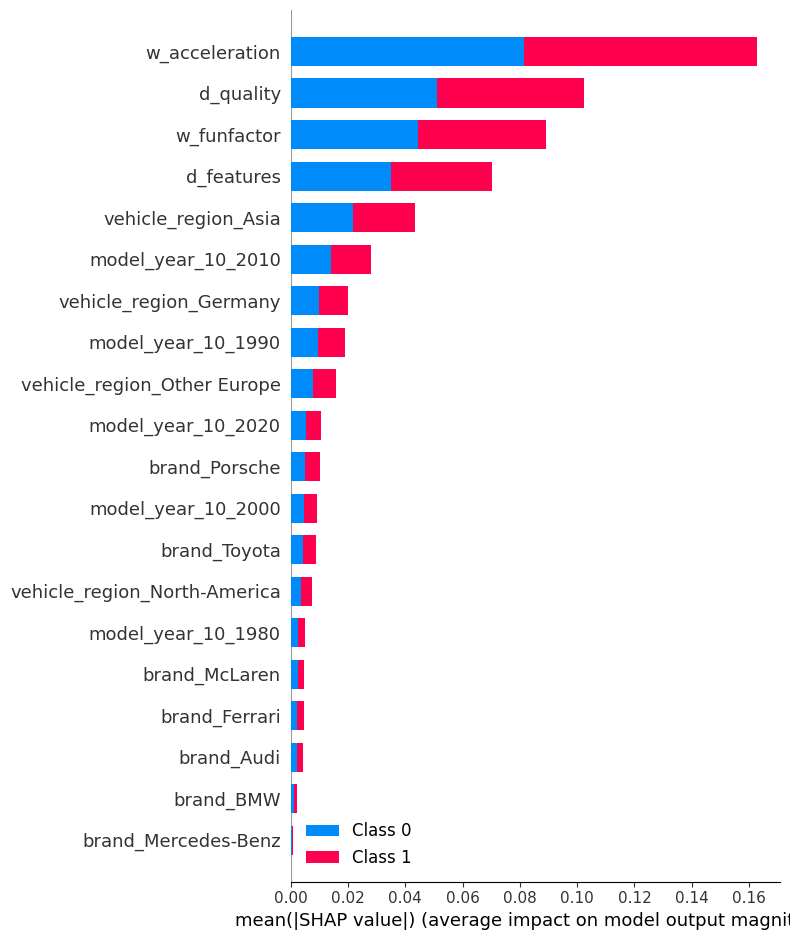

Training MSE: [9.00858995 9.2059677  8.51704334 8.67825933 6.124214  ]
Validation MSE: [32.80308055 13.87999895 21.17585982 23.97401554 82.06795387]
Mean training MSE: 8.306814865727494
Mean validation MSE: 34.780181746088466


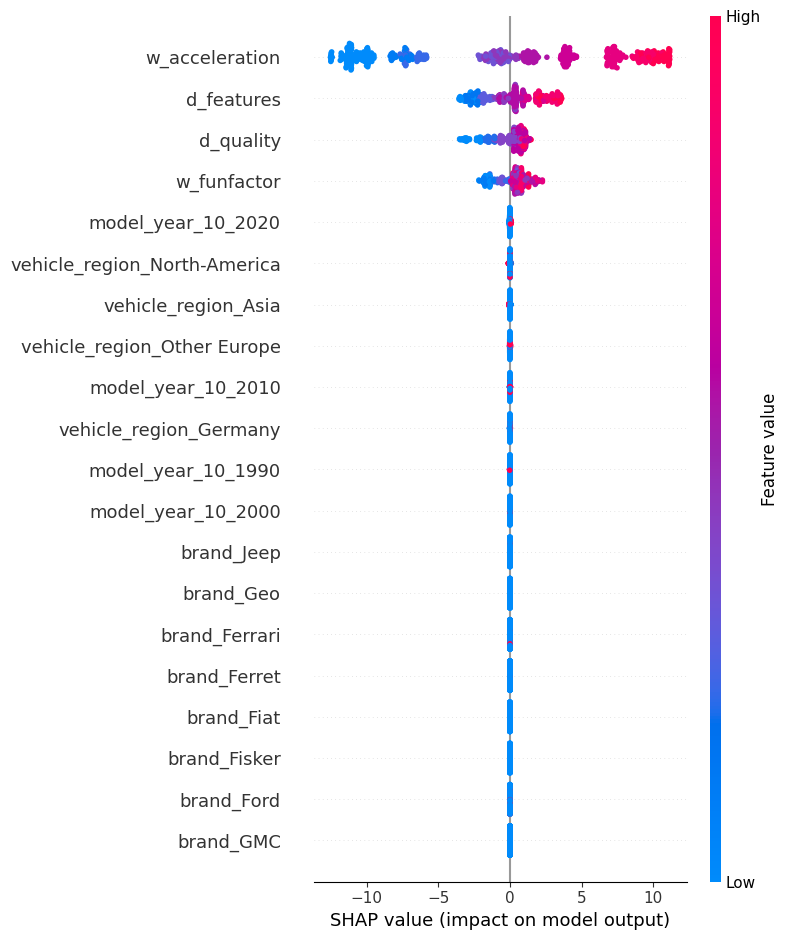

In [60]:

from sklearn.ensemble import RandomForestClassifier
# here we amplify our data by creating a random forest approach as a classifier to understand it better
# the earlier tree maxed out at 7 levels of depth and was only able to validate at about 0.64 which is not great
# here we try to amplify the data by using a random forest approach to learn different aspects of the data and then 
# create a classifier to understand it better the relationships between the data points


## Ranodm Forest
"""
# Create a random forest classifier and fit it to the data
clf = RandomForestClassifier(n_estimators=100, max_depth=7, random_state=42)
# Perform 5-fold cross-validation
cv_results = cross_validate(clf, X, y, cv=5, return_train_score=True)
# Print the cross-validation results
print('Training scores:', cv_results['train_score'])
print('Validation scores:', cv_results['test_score'])
print('Mean training score:', cv_results['train_score'].mean())
print('Mean validation score:', cv_results['test_score'].mean())
"""
# Example usage
daily = ['d_features', 'd_quality']#['d_comfort', 'd_practicality', 'd_value', 'd_features', 'd_quality']
weekend = ['w_acceleration','w_funfactor']# ['w_acceleration', 'handling', 'w_funfactor', 'w_styling', 'w_cool_factor']
meta = ['model_year_10', 'vehicle_region', 'brand'] #['brand', 'film_region', 'film_country', 'vehicle_region']

# Criteria example: Only consider rows where 'd_comfort' is greater than 5
criteria_func = lambda df: df['d_comfort'] > 0

# Call the function
forest = train_random_forest(df, daily_columns=daily, weekend_columns=weekend, meta_columns=meta, criteria=criteria_func, tree_depth=5,quantile=2, n_trees=100)
forest_r = train_random_forest_regression(df, daily_columns=daily, weekend_columns=weekend, meta_columns=meta, criteria=criteria_func, tree_depth=5, n_trees=100)

#plt.figure(figsize=(80,40))
#plot_tree(forest, feature_names=list(X.columns), class_names=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'], filled=True)
#plt.show()


In [61]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_validate
import pandas as pd

def train_gradient_boost_tree(df, 
                              daily_columns=[], 
                              weekend_columns=[], 
                              meta_columns=[], 
                              criteria=None, 
                              tree_depth=7, 
                              quantile=5,
                              n_estimators=1000,
                              learning_rate=0.01):
    
    # Apply criteria if provided
    filtered_df = df
    if criteria:
        filtered_df = df[criteria(df)]

    # Combine the columns
    active_columns = []
    active_columns.extend(daily_columns)
    active_columns.extend(weekend_columns)
    active_columns.extend(meta_columns)

    # Preprocess data
    X = filtered_df[active_columns]
    cat_features = meta_columns
    encoder = OneHotEncoder()
    X_encoded = encoder.fit_transform(X[cat_features])
    X_encoded_df = pd.DataFrame(X_encoded.toarray(), columns=encoder.get_feature_names_out(cat_features))
    X = pd.concat([X.drop(cat_features, axis=1), X_encoded_df], axis=1)
    filtered_df['doug_quantile'] = pd.qcut(df['dougscore'], q=quantile, labels=False)
    y = filtered_df['doug_quantile']

    # Train the gradient boosting tree
    gbc = GradientBoostingClassifier(n_estimators=n_estimators, min_samples_leaf=10, min_samples_split=20, learning_rate=learning_rate, max_depth=tree_depth, random_state=42)
    cv_results = cross_validate(gbc, X, y, cv=5, return_train_score=True)
    
    print('Training scores:', cv_results['train_score'])
    print('Validation scores:', cv_results['test_score'])
    print('Mean training score:', cv_results['train_score'].mean())
    print('Mean validation score:', cv_results['test_score'].mean())
    
    gbc.fit(X, y)
    
    return gbc
train_gradient_boost_tree(df, daily_columns=daily, weekend_columns=weekend, meta_columns=meta, criteria=criteria_func, tree_depth=5,quantile=2, n_estimators=1000, learning_rate=0.001)

# plt.show()

Training scores: [0.97649573 0.9465812  0.94017094 0.93162393 0.96581197]
Validation scores: [0.78632479 0.96581197 1.         0.91452991 0.76068376]
Mean training score: 0.9521367521367521
Mean validation score: 0.8854700854700855


GradientBoostingClassifier(learning_rate=0.001, max_depth=5,
                           min_samples_leaf=10, min_samples_split=20,
                           n_estimators=1000, random_state=42)

Training MSE: [3.46892156 3.10468403 2.93407297 3.03119001 2.33413309]
Validation MSE: [22.17053616 11.20300395 13.74261563 14.03428951 60.74332894]
Mean training MSE: 2.9746003337897333
Mean validation MSE: 24.378754839928977
RSME training: 1.7247029697283336
RSME validation: 4.937484667310773


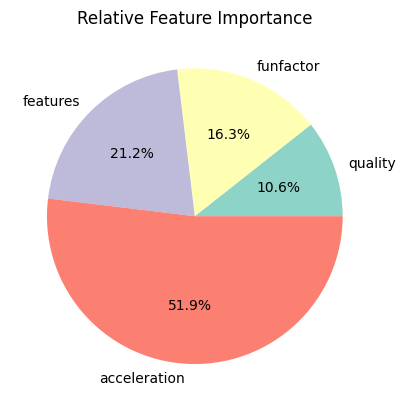

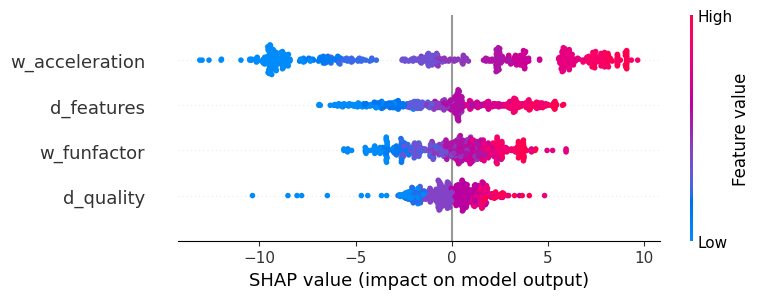

GradientBoostingRegressor(learning_rate=0.001, max_depth=5,
                          min_samples_split=20, n_estimators=5000,
                          random_state=42)

In [62]:
from sklearn.ensemble import GradientBoostingRegressor

def train_gradient_boost_tree_regression(df, 
                              daily_columns=[], 
                              weekend_columns=[], 
                              meta_columns=[], 
                              criteria=None, 
                              tree_depth=7, 
                              n_estimators=1000,
                              learning_rate=0.01):
    
    # Apply criteria if provided
    filtered_df = df
    if criteria:
        filtered_df = df[criteria(df)]

    # Combine the columns
    active_columns = []
    active_columns.extend(daily_columns)
    active_columns.extend(weekend_columns)
    # active_columns.extend(meta_columns)

    # Preprocess data
    X = filtered_df[active_columns]
    cat_features = [] # meta_columns
    encoder = OneHotEncoder()
    X_encoded = encoder.fit_transform(X[cat_features])
    X_encoded_df = pd.DataFrame(X_encoded.toarray(), columns=encoder.get_feature_names_out(cat_features))
    X = pd.concat([X.drop(cat_features, axis=1), X_encoded_df], axis=1)
    feature_names=X.columns.map(lambda x: re.sub("^\w_", "",x))
    
    # For regression, use the continuous 'dougscore' as the target variable
    y = filtered_df['dougscore']

    # Train the gradient boosting regressor
    gbr = GradientBoostingRegressor(n_estimators=n_estimators, min_samples_split=20, learning_rate=learning_rate, max_depth=tree_depth, random_state=42)
    cv_results = cross_validate(gbr, X, y, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
    
    print('Training MSE:', -cv_results['train_score'])
    print('Validation MSE:', -cv_results['test_score'])
    print('Mean training MSE:', -cv_results['train_score'].mean())
    print('Mean validation MSE:', -cv_results['test_score'].mean())
    print('RSME training:', np.sqrt(-cv_results['train_score'].mean()))
    print('RSME validation:', np.sqrt(-cv_results['test_score'].mean()))
    gbr.fit(X, y)


    shap.initjs()
    explainer = shap.TreeExplainer(gbr)
    shap_values = explainer.shap_values(X)

    # Compute the mean SHAP values for each feature
    mean_shap_values = np.mean(np.abs(shap_values), axis=0)
    # Get the indices of the features sorted by their mean SHAP values
    sorted_indices = np.argsort(mean_shap_values)
    # Compute the relative importance of each feature
    relative_importance = mean_shap_values[sorted_indices] / np.sum(mean_shap_values[sorted_indices])
    # Create a pie chart
    plt.figure()
    plt.pie(relative_importance, labels=feature_names[sorted_indices], autopct='%1.1f%%', colors=plt.cm.Set3(np.arange(len(X.columns[sorted_indices]))))
    plt.title('Relative Feature Importance')
    plt.show()

    # Visualize the summary of SHAP values with a summary plot
    shap.summary_plot(shap_values, X)
    plt.show()   

    
    return gbr

train_gradient_boost_tree_regression(df, daily_columns=daily, weekend_columns=weekend, meta_columns=meta, criteria=criteria_func, tree_depth=5, n_estimators=5000, learning_rate=0.001)

# In summary: Our model has an RMSE of 4.36, which means that on average, our predictions are off by about 4.36 units. Given the range of scores from 25 to 72, this represents an error of approximately 8.72% of the range. 
# This level of precision is acceptable for our application because we are not trying to predict the exact score of a car, but rather to predict where a car might land. 
